In [1]:
import torch
from torch import nn, utils
import torchvision

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import cv2
from tqdm import tqdm

In [3]:
# download data and unzip
url = 'https://gitlab.com/yuxuan.chen/'\
    'storage/-/blob/master/Deep-Learning-Examples/'\
    'fairface-img-margin025-trainval.zip'
data_dir = '../../storage/Deep-Learning-Examples/'
data_filename = 'fairface-img-margin025-trainval.zip'
data_path = data_dir + 'fairface-img-margin025-trainval/'

os.system('wget -nc {} -P {}'.format(url, data_dir))
if not os.path.exists(data_path):
    os.system('unzip {} -d {} > /dev/null'.format(
        data_dir + data_filename, data_dir))

train_df = pd.read_csv(
    data_path + 'fairface_label_train.csv').head(5120)
val_df = pd.read_csv(
    data_path + 'fairface_label_val.csv').head(128)

# we notice age is given by inteval, here we assign exact values
def specify_age(age_str):
    if age_str == 'more than 70':
        return 75
    return int(age_str.split('-')[-1]) - 4
train_df['age'] = train_df['age'].apply(specify_age)
val_df['age'] = val_df['age'].apply(specify_age)
print(train_df.head())
print(val_df.head())

          file  age  gender        race  service_test
0  train/1.jpg   55    Male  East Asian          True
1  train/2.jpg   35  Female      Indian         False
2  train/3.jpg    5  Female       Black         False
3  train/4.jpg   25  Female      Indian          True
4  train/5.jpg   25  Female      Indian          True
        file  age  gender             race  service_test
0  val/1.jpg    5    Male       East Asian         False
1  val/2.jpg   55  Female       East Asian          True
2  val/3.jpg   35    Male            White          True
3  val/4.jpg   25  Female  Latino_Hispanic          True
4  val/5.jpg   25    Male  Southeast Asian         False


In [7]:
# hyper-parameters
num_epochs = 5
batch_size = 64
learning_rate = 0.002
weight_decay = 0.002
dropout = 0.4

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def df_to_numpy(df):
    images, labels = [], []
    for idx in tqdm(range(len(df))):
        row = df.iloc[idx].squeeze()
        file, age, gender = \
            row['file'], row['age'], bool(row['gender'] == 'Female')

        # get image and label
        image = cv2.imread(data_path + str(file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      
        label = (int(age), int(gender))
        
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)


train_x, train_y = map(torch.tensor, df_to_numpy(train_df))
val_x, val_y = map(torch.tensor, df_to_numpy(val_df))
train_dataset = utils.data.TensorDataset(train_x, train_y)
val_dataset = utils.data.TensorDataset(val_x, val_y)        

100%|██████████| 128/128 [00:00<00:00, 140.84it/s]


In [5]:
def collate_fn(batch):
    images, ages, genders = [], [], []
    normalize = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])

    for image, label in batch:
        image = torch.tensor(image).permute(2, 0, 1)
        image = normalize(image / 255.)
        age, gender = label

        images.append(image)
        ages.append(float(age/75.))
        genders.append(float(gender))
        
    images = torch.stack(images)
    ages = torch.tensor(ages)
    genders = torch.tensor(genders)
    return images, ages, genders
       

# create data loader
train_loader = utils.data.DataLoader(dataset=train_dataset,
                                     batch_size=batch_size,
                                     drop_last=True,
                                     collate_fn=collate_fn,
                                     shuffle=True,
                                     pin_memory=True)
val_loader = utils.data.DataLoader(dataset=val_dataset,
                                   batch_size=batch_size,
                                   collate_fn=collate_fn,
                                   shuffle=False,
                                   pin_memory=True)  

In [5]:
# build model
class AgeGenderClassifier(nn.Module):
    def __init__(self, dropout=0):
        super(AgeGenderClassifier, self).__init__()

        self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128,64),
                nn.ReLU())

        self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid())
        self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid())
        
    def forward(self, x):
        x = self.intermediate(x)
        age = torch.squeeze(self.age_classifier(x))
        gender = torch.squeeze(self.gender_classifier(x))
        return age, gender


class VGG16(nn.Module):
    def __init__(self, dropout=0):
        super(VGG16, self).__init__()

        self.vgg = torchvision.models.vgg16(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.vgg.avgpool = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten())
        self.vgg.classifier = AgeGenderClassifier(dropout)

    def forward(self, x):
        out = self.vgg(x)
        return out

In [7]:
# set model, loss function and optimizer
model = VGG16().to(device)
print(model)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

VGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

In [8]:
def accuracy(outputs, labels):
    assert outputs.size(0) == labels.size(0)
    pred = (outputs > 0.5).squeeze()
    total = labels.size(0)
    hit = (pred == labels).sum()          
    return 1.0 * hit / total

In [9]:
for epoch in range(num_epochs):
    model.train()
    for images, ages, genders in train_loader: 
        images = images.to(device)
        ages, genders = ages.to(device), genders.to(device)

        # forward pass
        pred_ages, pred_genders = model(images)
        age_loss = age_criterion(pred_ages, ages)
        gender_loss = gender_criterion(pred_genders, genders)
        loss = age_loss + gender_loss
        gender_acc = accuracy(pred_genders, genders)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print the result for the last batch of this epoch
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
            epoch + 1, num_epochs, loss.item()))
    print('Training Accuracy for Gender: {:.3f}%'.format(
            100 * gender_acc))
    print('Training Loss for Age: {:.4f}'.format(
            age_loss.item()))

    # validate after each epoch
    model.eval()
    gender_accuracies = []
    with torch.no_grad():
        for images, ages, genders in val_loader: 
            images = images.to(device)
            ages, genders = ages.to(device), genders.to(device)

            pred_ages, pred_genders = model(images)
            gender_acc = accuracy(pred_genders, genders)
            age_loss = age_criterion(pred_ages, ages)
            gender_accuracies.append(gender_acc)
    print('Validation Accuracy for Gender: {:.3f}%'.format(
            100 * sum(gender_accuracies) / len(gender_accuracies)))
    print('Validation Loss for Age: {:.4f}'.format(
            age_loss.item()))
    print('=' * 50)
        
torch.save(model.state_dict(), './saved_model.ckpt')          

Epoch [1/5], Training Loss: 0.8513
Training Accuracy for Gender: 65.625%
Training Loss for Age: 0.1229
Validation Accuracy for Gender: 69.531%
Validation Loss for Age: 0.1289
Epoch [2/5], Training Loss: 0.5826
Training Accuracy for Gender: 75.000%
Training Loss for Age: 0.1343
Validation Accuracy for Gender: 74.219%
Validation Loss for Age: 0.1392
Epoch [3/5], Training Loss: 0.5333
Training Accuracy for Gender: 82.812%
Training Loss for Age: 0.1361
Validation Accuracy for Gender: 74.219%
Validation Loss for Age: 0.1298
Epoch [4/5], Training Loss: 0.3611
Training Accuracy for Gender: 95.312%
Training Loss for Age: 0.1614
Validation Accuracy for Gender: 78.906%
Validation Loss for Age: 0.1332
Epoch [5/5], Training Loss: 0.2442
Training Accuracy for Gender: 95.312%
Training Loss for Age: 0.0984
Validation Accuracy for Gender: 75.781%
Validation Loss for Age: 0.1220


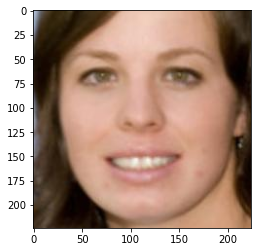

Predicted age: 24, predicted gender: Female


In [8]:
# read jpg and plot
file_path = data_path + 'val/516.jpg'#866
image = cv2.imread(file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# pre-processing
image = torch.tensor(image).permute(2, 0, 1)
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225])
image = normalize(image/255.).unsqueeze(0)

# load the saved model
saved_model = VGG16().to(device)
saved_model.load_state_dict(
    torch.load('./saved_model.ckpt', map_location=device))

saved_model.eval()
with torch.no_grad():
    image = image.to(device)
    pred_age, pred_gender = saved_model(image)
print('Predicted age: {}, predicted gender: {}'.format(
    int(pred_age * 75), 'Female' if pred_gender > 0.5 else 'Male'))